In [2]:
import numpy as np
from scipy.sparse.linalg import expm
from scipy.constants import hbar, pi
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from sim_functions import time_evolve, gen_ham_free, gen_ham_plus, gen_ham_minus

# Note: double check these at some point
m = 85.47*1.6605e-27 # Rb-85 mass
kb = 1.38064852e-23 # Boltzmann's constant
omega_2 = 2*pi*(384.230406373e12 - 1.264888e9) # Beam 2 freq.
omega_1 = 2*pi*(384.230406373e12 + 1.770843e9) # Beam 1 freq.
omega_eg = omega_1 - omega_2 # Hyperfine splitting.
k_eff = (omega_1+omega_2)/(2.998e8) # Effective wavevector.
dR = (hbar*(k_eff)**2)/(2*m) # two-photon recoil shift
print(dR/2*pi)


151374.93221726542


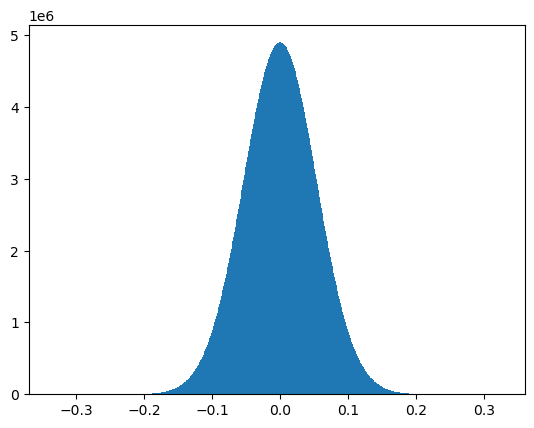

In [ ]:
N = 1000000000
Temp = 30e-6
sigma = np.sqrt(kb*Temp/m)

atom_veloc = np.random.normal(loc = 0, scale = sigma, size = N)

plt.hist(atom_veloc,bins = 1000)
plt.show()

### Rabi flops

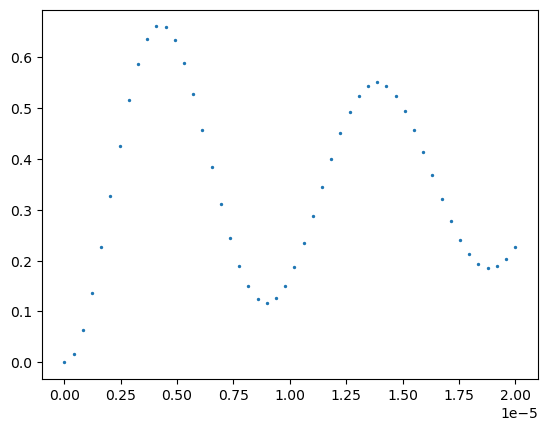

In [4]:
N = 1000
Temp = 10e-6
sigma = np.sqrt(kb*Temp/m)
atom_veloc = np.random.normal(loc = 0, scale = sigma, size = N)

n_min = 0
n_max = 1
n_tot = n_max - n_min + 1
basis = np.arange(n_min, n_max + 1)

# Detuning and laser phase has to be updated here for all the following cells
Rabi_plus = 2*pi*100000
Rabi_minus = 2*pi*100000
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus

Hplus = gen_ham_plus(basis = basis,
                  phi_L = 0,
                  omega_R_plus = Rabi_plus,
)

time = np.linspace(0, Rabi_plus_time*2, 50)
time_step = time[1]-time[0]
# Atoms are rows, time is along columns. rows then get summed up to be averaged
data = np.zeros((N,len(time)))

state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)


for t in range(len(time)):
    for v in range(len(atom_veloc)):
        state_vec[0] = 1
        state_vec[1] = 0

        H0 = gen_ham_free(basis = basis,
                        delta_L = dR,
                        delta_D = k_eff*atom_veloc[v],
                        delta_R = dR,
        )

        state_vec = time_evolve(time[t], Hplus + H0) @ state_vec

        square = np.abs(state_vec)**2
        data[v,t] = square[1][0]

excited_fraction = np.sum(data, axis=0)/N
plt.scatter(time,excited_fraction,s=2)
plt.show()



### MZI

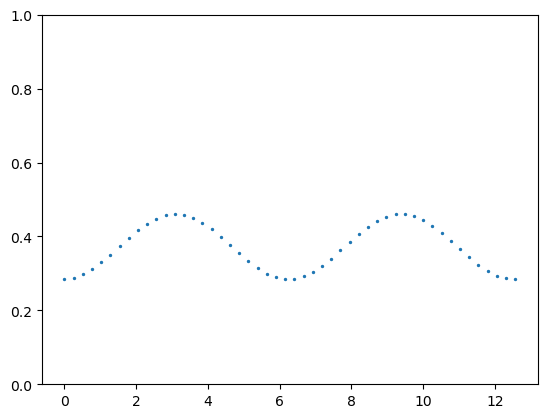

In [ ]:
N = 1000
Temp = 50e-6
sigma = np.sqrt(kb*Temp/m)
atom_veloc = np.random.normal(loc = 0, scale = sigma, size = N)

n_min = 0
n_max = 1
n_tot = n_max - n_min + 1
basis = np.arange(n_min, n_max + 1)

# Detuning and laser phase has to be updated here for all the following cells
Rabi_plus = 2*pi*100000
Rabi_minus = 2*pi*100000
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus

Hplus = gen_ham_plus(basis = basis,
                  phi_L = 0,
                  omega_R_plus = Rabi_plus,
)

T = 100*Rabi_plus_time
phase_range = np.linspace(0, 4*pi, 50)

# Atoms are rows, phases are along columns. rows then get summed up to be averaged
data = np.zeros((N,len(phase_range)))

state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)


for p in range(len(phase_range)):
    Hplusphase = gen_ham_plus(basis=basis, phi_L = phase_range[p], omega_R_plus = Rabi_plus)
    for v in range(len(atom_veloc)):
        state_vec[0] = 1
        state_vec[1] = 0

        H0 = gen_ham_free(basis = basis,
                        delta_L = dR,
                        delta_D = k_eff*atom_veloc[v],
                        delta_R = dR,
        )

        state_vec = time_evolve(time[t], Hplus + H0) @ state_vec

        state_vec = time_evolve(Rabi_plus_time/4, Hplus + H0) @ state_vec

        state_vec = time_evolve(T, H0) @ state_vec

        state_vec = time_evolve(Rabi_plus_time/2, Hplus + H0) @ state_vec
    
        state_vec = time_evolve(T, H0) @ state_vec

        state_vec = time_evolve(Rabi_plus_time/4, Hplusphase + H0) @ state_vec

        square = np.abs(state_vec)**2
        data[v,p] = square[1][0]

excited_fraction = np.sum(data, axis=0)/N
plt.scatter(phase_range,excited_fraction,s=2)
plt.ylim((0,1))
plt.show()

